In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('/home/fractaluser/Downloads/driver_n_rollout')
pd.set_option('display.max_columns', None)
sns.set(font_scale = 1, style = 'whitegrid')
from sklearn.metrics import mean_squared_error
import random, time
from pandas import Interval
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
import xgboost as xgb

In [47]:
data = pd.read_csv('adult.csv')

In [48]:
data.head()

,age,workclass,education,marital_status,employment,relationship,race,gender,workhours,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,<=50K


In [49]:
data = data.drop(labels = ['employment', 'relationship'], axis = 1)

data = data[(data.education != ' 11th') & (data.education != ' Assoc-voc') & (data.education != ' Assoc-acdm')
           & (data.education != ' 7th-8th') & (data.education != ' Prof-school') & (data.education != ' 9th') 
           & (data.education != ' 5th-6th') & (data.education != ' 1st-4th') & (data.education != ' Preschool') 
           & (data.marital_status != ' Married-AF-spouse') & (data.workclass != ' ?') 
           & (data.workclass != ' Self-emp-not-inc') & (data.workclass != ' Self-emp-inc')].reset_index(drop = True)

In [50]:
numerical_data = data.copy()

lbl1 = LabelEncoder()
numerical_data.gender = lbl1.fit_transform(numerical_data.gender)

lbl2 = LabelEncoder()
numerical_data.income = lbl2.fit_transform(numerical_data.income)

lbl3 = LabelEncoder()
numerical_data.marital_status = lbl3.fit_transform(numerical_data.marital_status)

lbl4 = LabelEncoder()
numerical_data.race = lbl4.fit_transform(numerical_data.race)

lbl5 = LabelEncoder()
numerical_data.workclass = lbl5.fit_transform(numerical_data.workclass)

In [51]:
numerical_data.head()

,age,workclass,education,marital_status,race,gender,workhours,income
0,39,4,Bachelors,3,4,1,40,0
1,38,3,HS-grad,0,4,1,40,0
2,28,3,Bachelors,1,2,0,40,0
3,37,3,Masters,1,4,0,40,0
4,31,3,Masters,3,4,0,50,1


In [52]:
numerical_data['age_group'] = pd.DataFrame({'age_group':pd.cut(numerical_data.age, 6)})
numerical_data['workhours_group'] = pd.DataFrame({'workhours_group':pd.cut(numerical_data.workhours, 6)})

numerical_data.education.replace([' 10th', ' 12th', ' HS-grad', ' Some-college', 
                                 ' Bachelors', ' Masters', ' Doctorate'], [1, 2, 3, 4, 5, 6, 7], inplace = True)
numerical_data.workhours_group.replace([Interval(0.902, 17.333, closed = 'right'), Interval(17.333, 33.667, closed='right')
                                  , Interval(33.667, 50.0, closed = 'right'), Interval(50.0, 66.333, closed = 'right'), 
                                 Interval(66.333, 82.667, closed = 'right'), Interval(82.667, 99.0, closed = 'right')]
                                 , [1, 2, 3, 4, 5, 6], inplace = True)
numerical_data.age_group.replace([Interval(16.927, 29.167, closed = 'right'), Interval(29.167, 41.333, closed='right')
                                  , Interval(41.333, 53.5, closed = 'right'), Interval(53.5, 65.667, closed = 'right'), 
                                 Interval(65.667, 77.833, closed = 'right'), Interval(77.833, 90.0, closed = 'right')]
                                 , [1, 2, 3, 4, 5, 6], inplace = True)

In [53]:
kmeans = KMeans(n_clusters = 6, random_state = 1)
clustering_model = kmeans.fit(numerical_data.drop(labels = ['age', 'workhours'], axis = 1))

In [54]:
numerical_data['cluster'] = pd.DataFrame({'cluster':clustering_model.labels_})

In [55]:
lift = []
for i in range(len(numerical_data)):
    if numerical_data.cluster[i] == 0:
        lift.append(np.round(random.uniform(-.8, -.5), 2))
    elif numerical_data.cluster[i] == 1:
        lift.append(np.round(random.uniform(-.5, -.2), 2))
    elif numerical_data.cluster[i] == 2:
        lift.append(0)
    elif numerical_data.cluster[i] == 3:
        lift.append(np.round(random.uniform(.1, .4),2))
    elif numerical_data.cluster[i] == 4:
        lift.append(np.round(random.uniform(.4, .7),2))
    else:
        lift.append(np.round(random.uniform(.7, 1.2),2))

In [56]:
numerical_data['lift'] = pd.DataFrame({'lift':lift})

change = numerical_data.sample(2000).index
numerical_data.loc[change,'lift'] = float(0)

In [57]:
training = numerical_data.drop(labels = ['lift', 'workhours', 'age', 'cluster'], axis = 1)
target = numerical_data['lift']

In [58]:
xdata, xtest, ydata, ytest = train_test_split(training, target, test_size = 0.25, random_state = 1)
xdata = xdata.reset_index(drop = True)
xtest = xtest.reset_index(drop = True)
ydata = ydata.reset_index(drop = True)
ytest = ytest.reset_index(drop = True)

In [59]:
xtrain, xval, ytrain, yval = train_test_split(xdata, ydata, test_size = 0.25, random_state = 1)
xtrain = xtrain.reset_index(drop = True)
xval = xval.reset_index(drop = True)
ytrain = ytrain.reset_index(drop = True)
yval = yval.reset_index(drop = True)

In [60]:
trial1 = time.time()
linear_model = LassoCV(eps=0.001, n_alphas=100, fit_intercept=True, precompute='auto', max_iter=1000 ,cv=2, n_jobs=-1, random_state=1, selection='cyclic')
regress = linear_model.fit(xdata, ydata)
print('Processing time =', time.time()-trial1, 'seconds')
lasso_performance = regress.predict(xtest)

Processing time = 0.21626996994018555 seconds


In [61]:
print('Error after lasso =', (mean_squared_error(ytest, lasso_performance))**0.5)

Error after lasso = 0.41022901505261655


In [62]:
print('Lasso reg. coefficients ->',regress.coef_)

Lasso reg. coefficients -> [-0.14973039 -0.12324     0.07507051  0.13457825 -0.00874128 -0.15551949
 -0.16746382 -0.04212665]


In [63]:
trial2 = time.time()
params = {"objective":"reg:linear",
          "booster":"gbtree",
          "eta":0.1,
          "max_depth": 3,
         "subsample":0.75,
         "silent":0,
         "seed":1,
         "lambda":.25,
         "alpha":.1}

num_boost_round = 1000

dtrain = xgb.DMatrix(xtrain, ytrain)
dvalid = xgb.DMatrix(xval, yval)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

booster = xgb.train(params, dtrain, num_boost_round, evals = watchlist, early_stopping_rounds = 25, verbose_eval=10)
print('Processing time =', time.time()-trial2, 'seconds')
performance = booster.predict(xgb.DMatrix(xtest))

[0]	train-rmse:0.537508	eval-rmse:0.534328
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 25 rounds.
[10]	train-rmse:0.301797	eval-rmse:0.297092
[20]	train-rmse:0.249766	eval-rmse:0.244255
[30]	train-rmse:0.235827	eval-rmse:0.229587
[40]	train-rmse:0.230545	eval-rmse:0.224145
[50]	train-rmse:0.227759	eval-rmse:0.221561
[60]	train-rmse:0.225338	eval-rmse:0.219206
[70]	train-rmse:0.224375	eval-rmse:0.218645
[80]	train-rmse:0.223093	eval-rmse:0.217713
[90]	train-rmse:0.222082	eval-rmse:0.216843
[100]	train-rmse:0.220533	eval-rmse:0.215342
[110]	train-rmse:0.219683	eval-rmse:0.214477
[120]	train-rmse:0.2189	eval-rmse:0.213842
[130]	train-rmse:0.218228	eval-rmse:0.21332
[140]	train-rmse:0.217538	eval-rmse:0.212814
[150]	train-rmse:0.217094	eval-rmse:0.212544
[160]	train-rmse:0.216628	eval-rmse:0.21247
[170]	train-rmse:0.216105	eval-rmse:0.211976
[180]	train-rmse:0.215645	eval-rmse:0.211645
[190]	train-rmse:

In [64]:
print('Error on test set =', mean_squared_error(ytest, performance)**.5)

Error on test set = 0.2127127638783534


In [65]:
test_pool = xdata.join(ydata)
target_pool = xtest.join(pd.DataFrame(booster.predict(xgb.DMatrix(xtest)))).rename(columns = {0:'lift'})

In [71]:
kmeans_specific = KMeans(n_clusters = 6, random_state = 1)
clustering_specific = kmeans_specific.fit(test_pool)
test_labels = clustering_specific.labels_
target_labels = clustering_specific.predict(target_pool)
test_pool['cluster'] = pd.DataFrame({'cluster':test_labels})
target_pool['cluster'] = pd.DataFrame({'cluster':target_labels})

In [102]:
for i in test_pool.cluster.unique():
    print('Cluster', i, 'mean lift =', np.mean(test_pool[(test_pool.cluster==i)].lift))

Cluster 2 mean lift = 0.22590248226950352
Cluster 0 mean lift = 0.8690799194089995
Cluster 4 mean lift = 0.0
Cluster 5 mean lift = 0.49342611000662695
Cluster 1 mean lift = -0.5912564407451418
Cluster 3 mean lift = -0.3151348435814458


In [103]:
for i in target_pool.cluster.unique():
    print('Cluster', i, 'mean lift =', np.mean(target_pool[(target_pool.cluster==i)].lift))

Cluster 1 mean lift = -0.5570791959762573
Cluster 0 mean lift = 0.8480566740036011
Cluster 2 mean lift = 0.22348754107952118
Cluster 3 mean lift = -0.26614803075790405
Cluster 4 mean lift = 0.0087205171585083
Cluster 5 mean lift = 0.49103057384490967


In [110]:
for i in test_pool.cluster.unique():
    cluster_data = test_pool[(test_pool.cluster==i)]
    cluster_target = target_pool[(target_pool.cluster==i)]
    
    

In [124]:
for i in range(len(sample.columns)-2):
    print(sample[sample.columns[i]].value_counts()/len(sample))

1    0.634195
0    0.365805
Name: workclass, dtype: float64
3    0.288933
5    0.263088
4    0.249834
6    0.181577
7    0.012591
2    0.001988
1    0.001988
Name: education, dtype: float64
1    0.611663
0    0.222001
3    0.151756
2    0.011928
4    0.002651
Name: marital_status, dtype: float64
4    0.856859
2    0.117296
1    0.016567
3    0.005964
0    0.003313
Name: race, dtype: float64
1    0.669317
0    0.330683
Name: gender, dtype: float64
0    0.59112
1    0.40888
Name: income, dtype: float64
3    0.394301
2    0.340623
4    0.155732
1    0.089463
5    0.017893
6    0.001988
Name: age_group, dtype: float64
3    0.831677
4    0.085487
2    0.041750
5    0.022531
1    0.014579
6    0.003976
Name: workhours_group, dtype: float64


In [66]:
complete_lift_prediction = booster.predict(xgb.DMatrix(training))
numerical_data['predicted_lift'] = pd.DataFrame({'predicted_lift':complete_lift_prediction})

complete_data = data.copy()
complete_data['predicted_lift'] = pd.DataFrame({'predicted_lift':complete_lift_prediction})
complete_data.age = pd.cut(complete_data.age, 6)
complete_data.workhours = pd.cut(complete_data.workhours, 6)

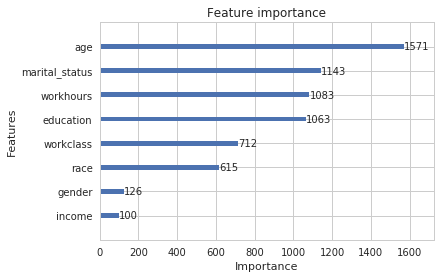

In [50]:
xgb.plot_importance(booster, xlabel='Importance', ylabel='Features')
plt.show()

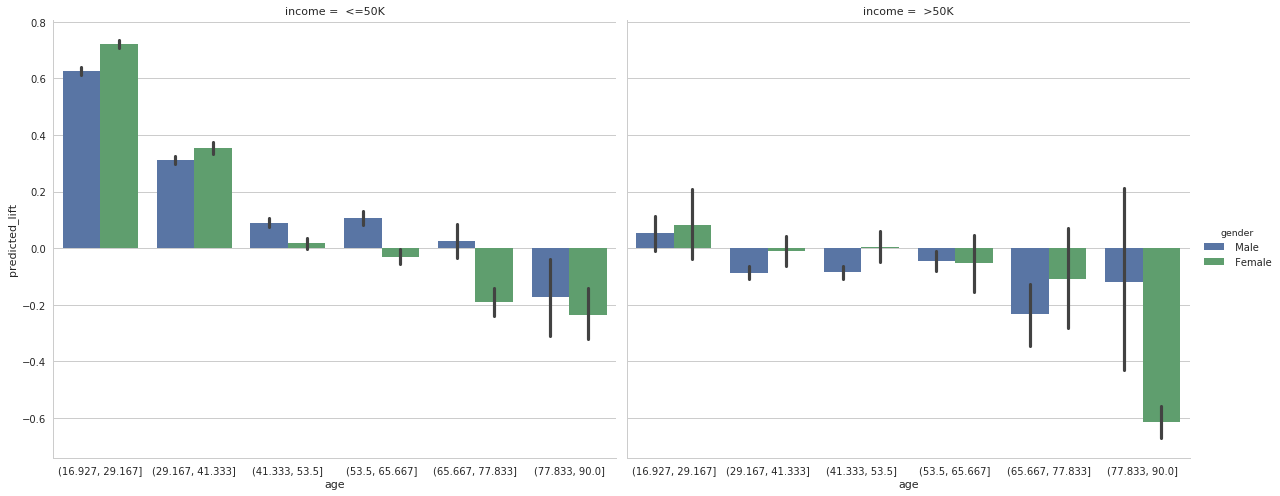

In [39]:
sns.factorplot(x="age", y="predicted_lift", hue="gender",
               col="income", data=complete_data, kind="bar", size = 7, aspect=1.2)
plt.show()

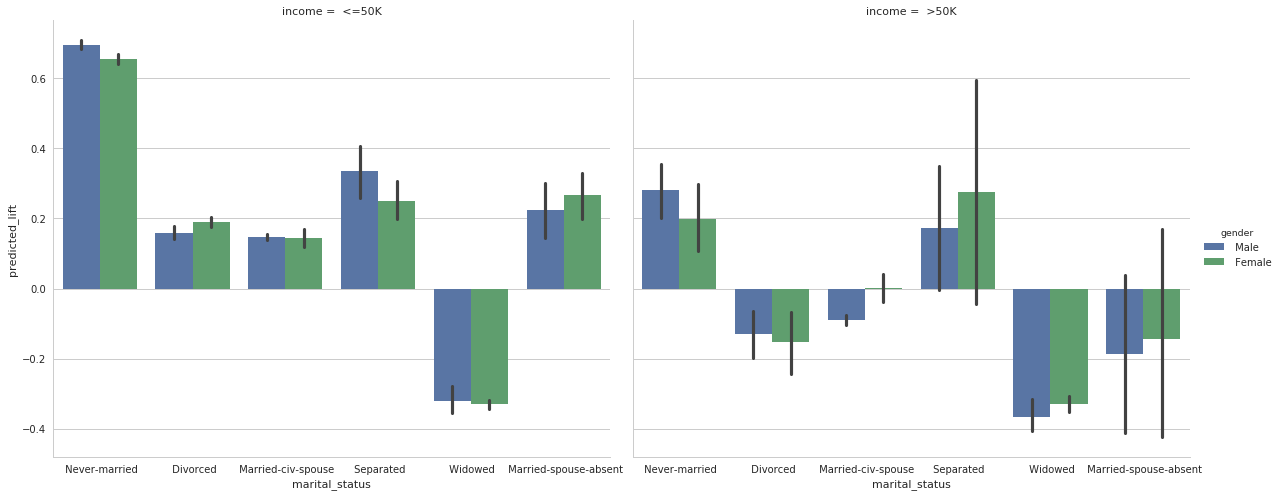

In [40]:
sns.factorplot(x="marital_status", y="predicted_lift", hue="gender",
               col="income", data=complete_data, kind="bar", size = 7, aspect=1.2)
plt.show()

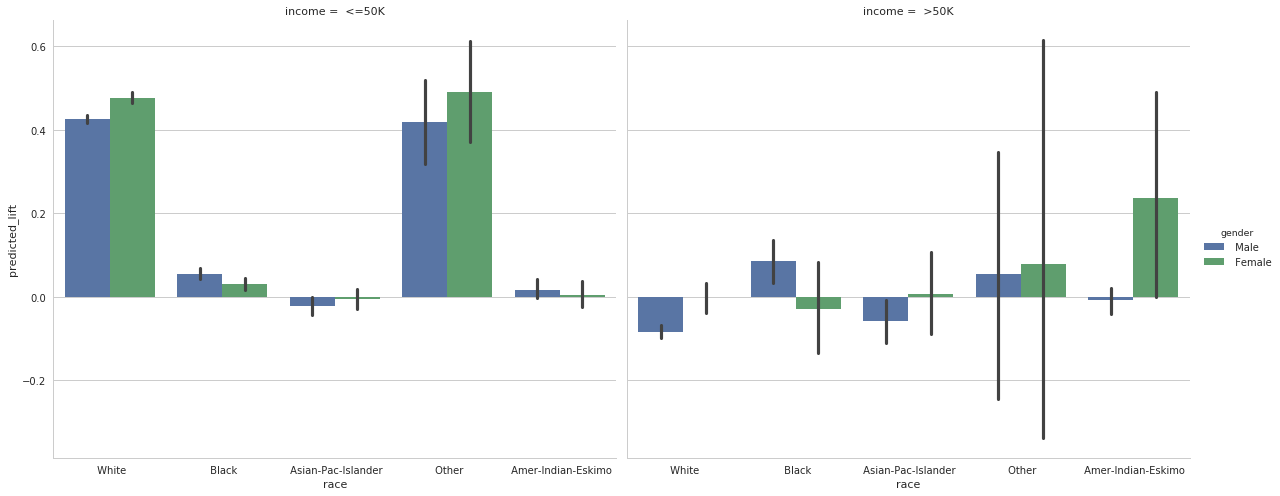

In [41]:
sns.factorplot(x="race", y="predicted_lift", hue="gender",
               col="income", data=complete_data, kind="bar", size = 7, aspect=1.2)
plt.show()

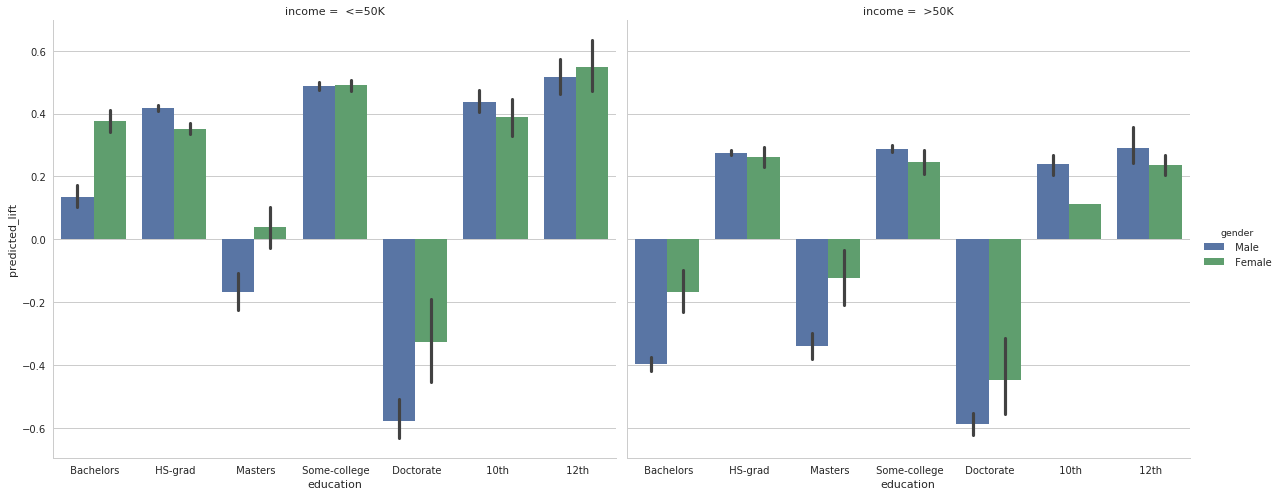

In [42]:
sns.factorplot(x="education", y="predicted_lift", hue="gender",
               col="income", data=complete_data, kind="bar", size = 7, aspect=1.2)
plt.show()

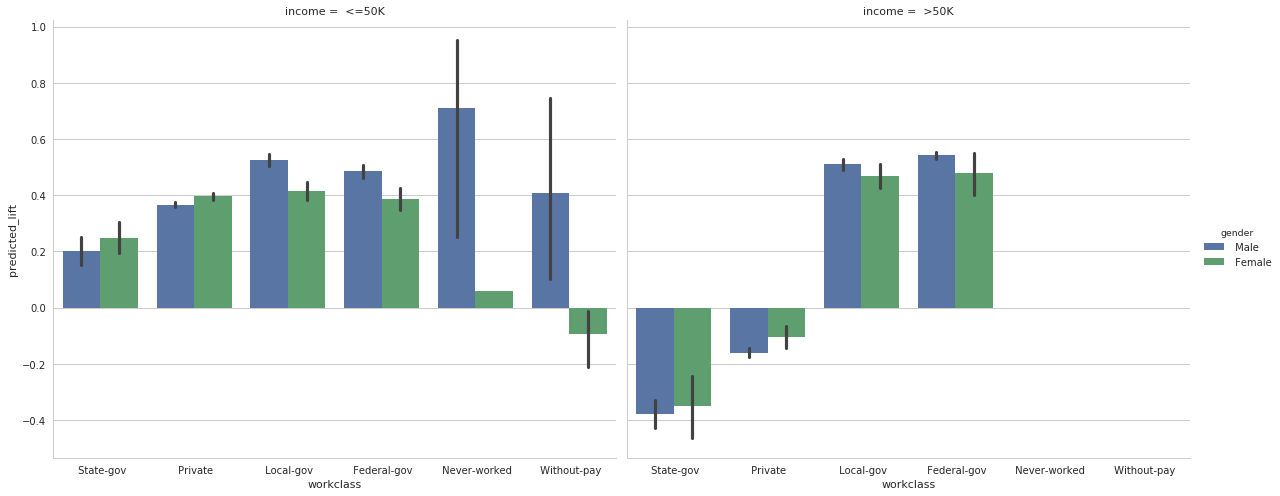

In [43]:
sns.factorplot(x="workclass", y="predicted_lift", hue="gender",
               col="income", data=complete_data, kind="bar", size = 7, aspect=1.2)
plt.show()

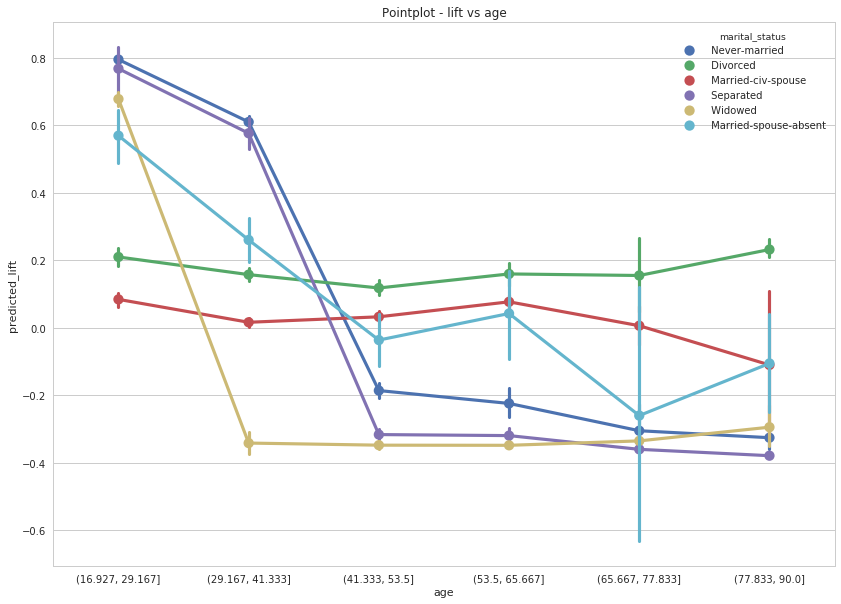

In [44]:
plt.figure(figsize = (14,10))
plt.title('Pointplot - lift vs age')
sns.pointplot(x="age", y="predicted_lift", data=complete_data, hue = 'marital_status')
plt.show()

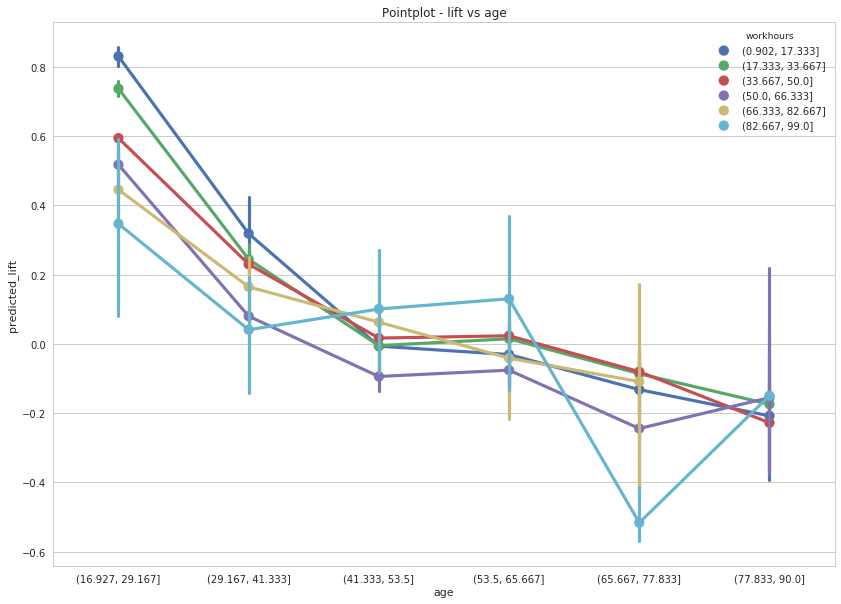

In [45]:
plt.figure(figsize = (14,10))
plt.title('Pointplot - lift vs age')
sns.pointplot(x="age", y="predicted_lift", data=complete_data, hue = 'workhours')
plt.show()

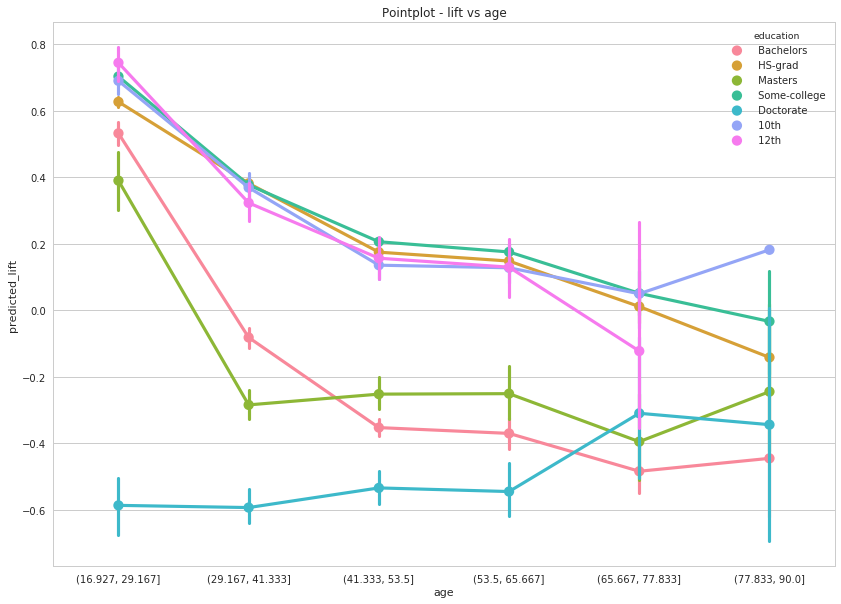

In [46]:
plt.figure(figsize = (14,10))
plt.title('Pointplot - lift vs age')
sns.pointplot(x="age", y="predicted_lift", data=complete_data, hue = 'education')
plt.show()

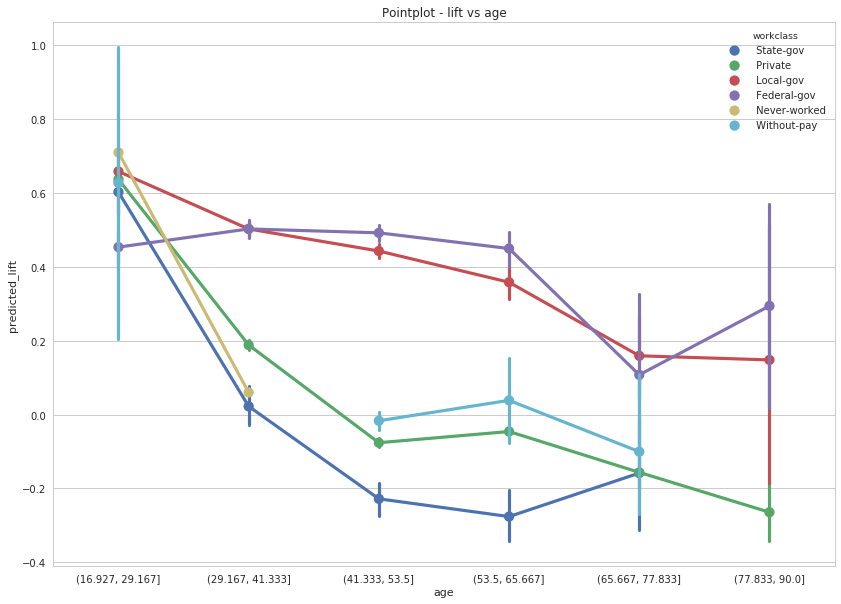

In [47]:
plt.figure(figsize = (14,10))
plt.title('Pointplot - lift vs age')
sns.pointplot(x="age", y="predicted_lift", data=complete_data, hue = 'workclass')
plt.show()

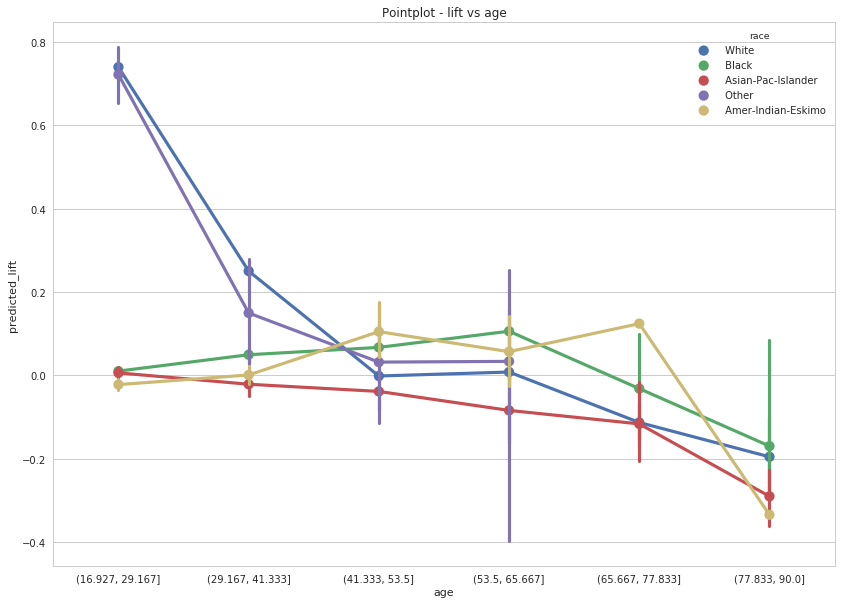

In [48]:
plt.figure(figsize = (14,10))
plt.title('Pointplot - lift vs age')
sns.pointplot(x="age", y="predicted_lift", data=complete_data, hue = 'race')
plt.show()

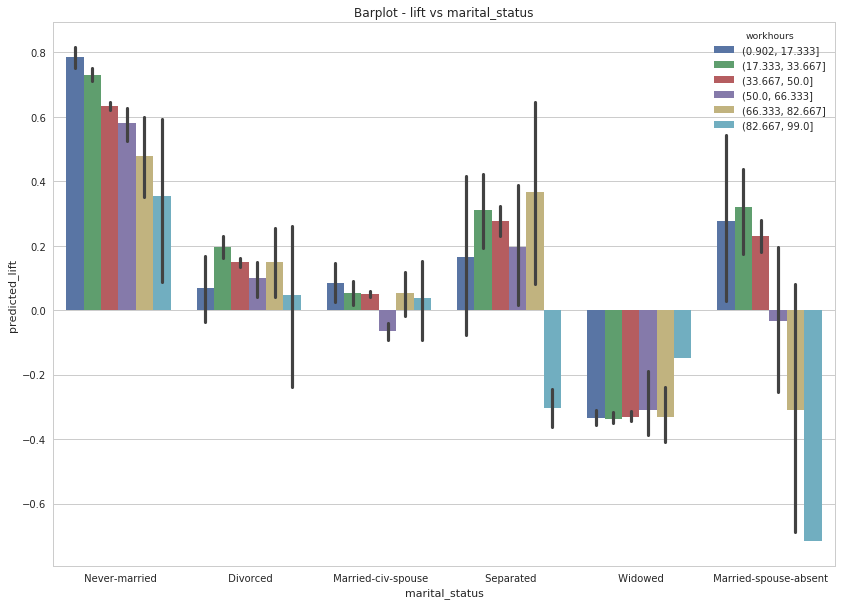

In [49]:
plt.figure(figsize = (14,10))
plt.title('Barplot - lift vs marital_status')
sns.barplot(x="marital_status", y="predicted_lift", data=complete_data, hue = 'workhours')
plt.show()

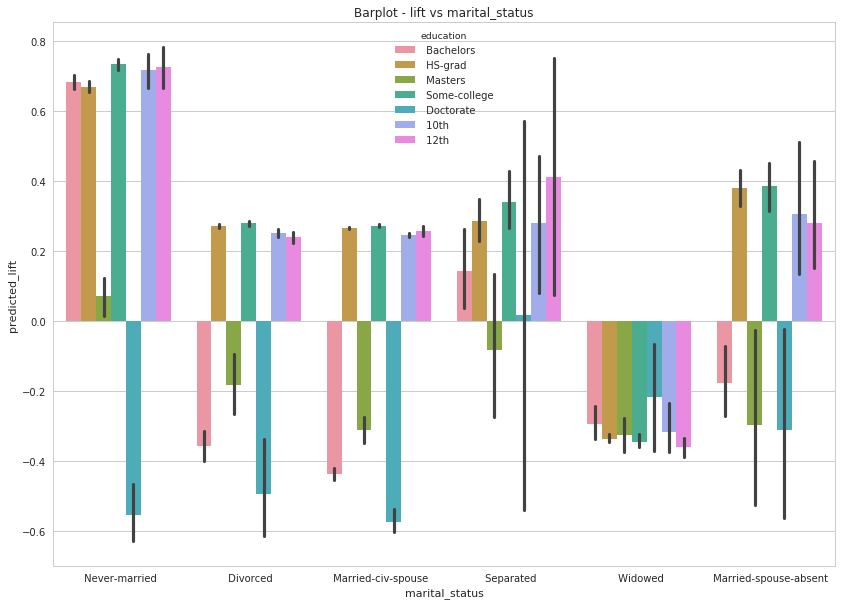

In [51]:
plt.figure(figsize = (14,10))
plt.title('Barplot - lift vs marital_status')
sns.barplot(x="marital_status", y="predicted_lift", data=complete_data, hue = 'education')
plt.show()

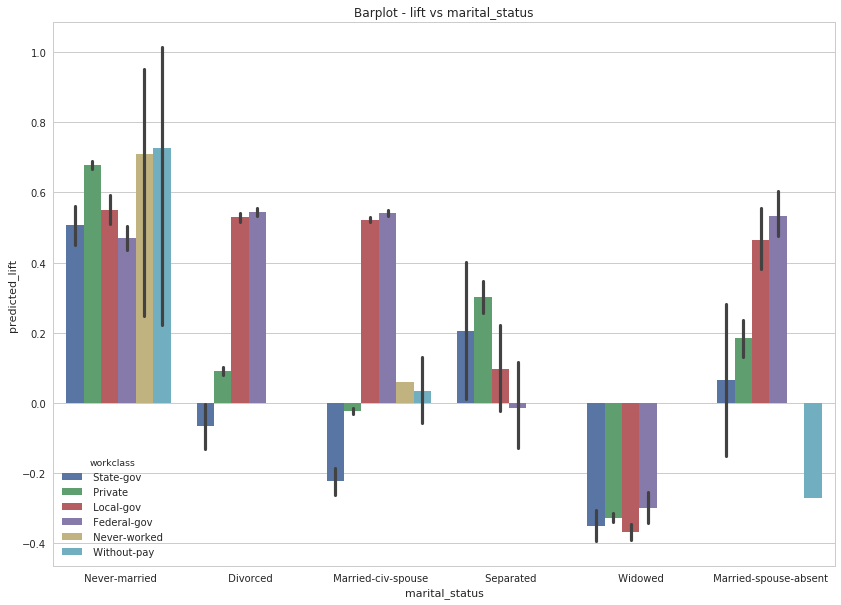

In [52]:
plt.figure(figsize = (14,10))
plt.title('Barplot - lift vs marital_status')
sns.barplot(x="marital_status", y="predicted_lift", data=complete_data, hue = 'workclass')
plt.show()

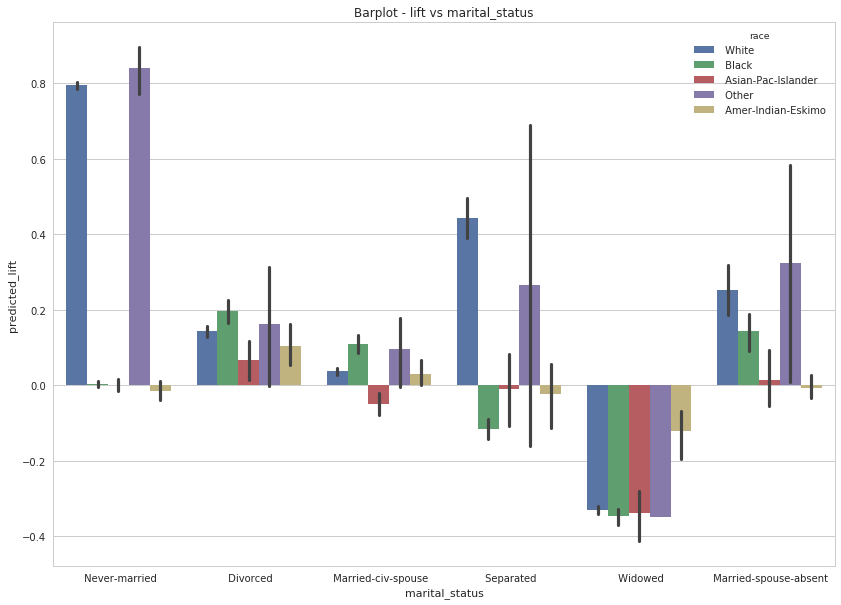

In [53]:
plt.figure(figsize = (14,10))
plt.title('Barplot - lift vs marital_status')
sns.barplot(x="marital_status", y="predicted_lift", data=complete_data, hue = 'race')
plt.show()

In [54]:
order_of_rolling_out = complete_data.copy()
order_of_rolling_out = order_of_rolling_out.sort_values(by='predicted_lift', ascending = False).reset_index(drop = True)

In [59]:
change = numerical_data.sample(2000).index
numerical_data.loc[change,'lift'] = float(0)

data_wo_zero = numerical_data[(numerical_data.lift!=0)]
data_w_zero = numerical_data[(numerical_data.lift==0)]

In [60]:
data_w_zero.cluster.value_counts()

2    2206
3     644
5     546
0     277
4     198
1     120
Name: cluster, dtype: int64

In [61]:
complete_data = pd.concat([data_wo_zero, data_w_zero[(data_w_zero.cluster==2)]]).reset_index(drop = True)

In [62]:
print('Retained proportion =', len(complete_data)/len(numerical_data))

Retained proportion = 0.9198868991517436
